In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from lvmdrp.utils.examples import get_frames_metadata
from lvmdrp.core import rss

from lvmdrp.functions import imageMethod
from lvmdrp.functions import rssMethod

plt.style.use("seaborn-v0_8-talk")

In [2]:
# define input data directory
data_path = os.path.abspath(os.path.join("..", "data"))

# let's create the output directory
output_path = os.path.join("data")
os.makedirs(output_path, exist_ok=True)

# create processed frames path template
out_main_path = os.path.join(output_path, "lvm-{kind}-{camera}-{expnum}.{ext}")
out_calib_path = os.path.join(output_path, "lvm-{mjd}-{kind}-{camera}-{exptime}.{ext}")

# extract metadata
frames_table = get_frames_metadata(path=os.path.join(data_path, "sim_2d"))
# group by imagetyp, camera and exptime
frames_table = frames_table.group_by(["imagetyp", "spec", "camera", "expnum", "exptime"])
# define groups and unique categories in those groups
frames_groups = frames_table.groups
unique_groups = frames_groups.keys

[INFO]: loading cached metadata from '/home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/sim_2d/frames_table.pkl'


[INFO]: reading guess lines from '../../python/lvmdrp/etc/lvm-neon_nist_b1.txt'
[INFO]: going to use fiber 21 as reference
[INFO]: number of guess lines in file 15 percentage masked  0 %
[INFO]: going to use 15 guess lines
[INFO]: reading arc from 'data/lvm-xarc-b1-00010001.fits'
[INFO]: calculating shift in guess lines using CC
[INFO]: maximum CC shift = -15 pix
[INFO]: measuring arc lines for each fiber from reference fiber 22, flux limits [200.0, 10.0] and relative flux limits [0.1, 5.0]


measuring arc lines upwards from ref_fiber = 21: 100%|################################################| 21/21 [00:00<00:00, 127.63fiber/s]
measuring arc lines downwards from ref_fiber = 21:   3%|#5                                            | 20/586 [00:00<00:12, 44.47fiber/s]

[WARNING]: Number of calls to function has reached maxfev = 9999. (RuntimeWarning)


measuring arc lines downwards from ref_fiber = 21: 100%|#############################################| 586/586 [00:16<00:00, 35.53fiber/s]


[INFO]: smoothing FWHM of guess lines along cross-dispersion axis using 2-deg polynomials
[INFO]: fitting wavelength solutions using 7-deg polynomials
[INFO]: finished wavelength fitting with median RMS = 0.207918 AA (0.358521 pix)
[INFO]: fitting LSF solutions using 7-deg polynomials
[INFO]: finished LSF fitting with median RMS = 0.399375 AA (0.692133 pix)


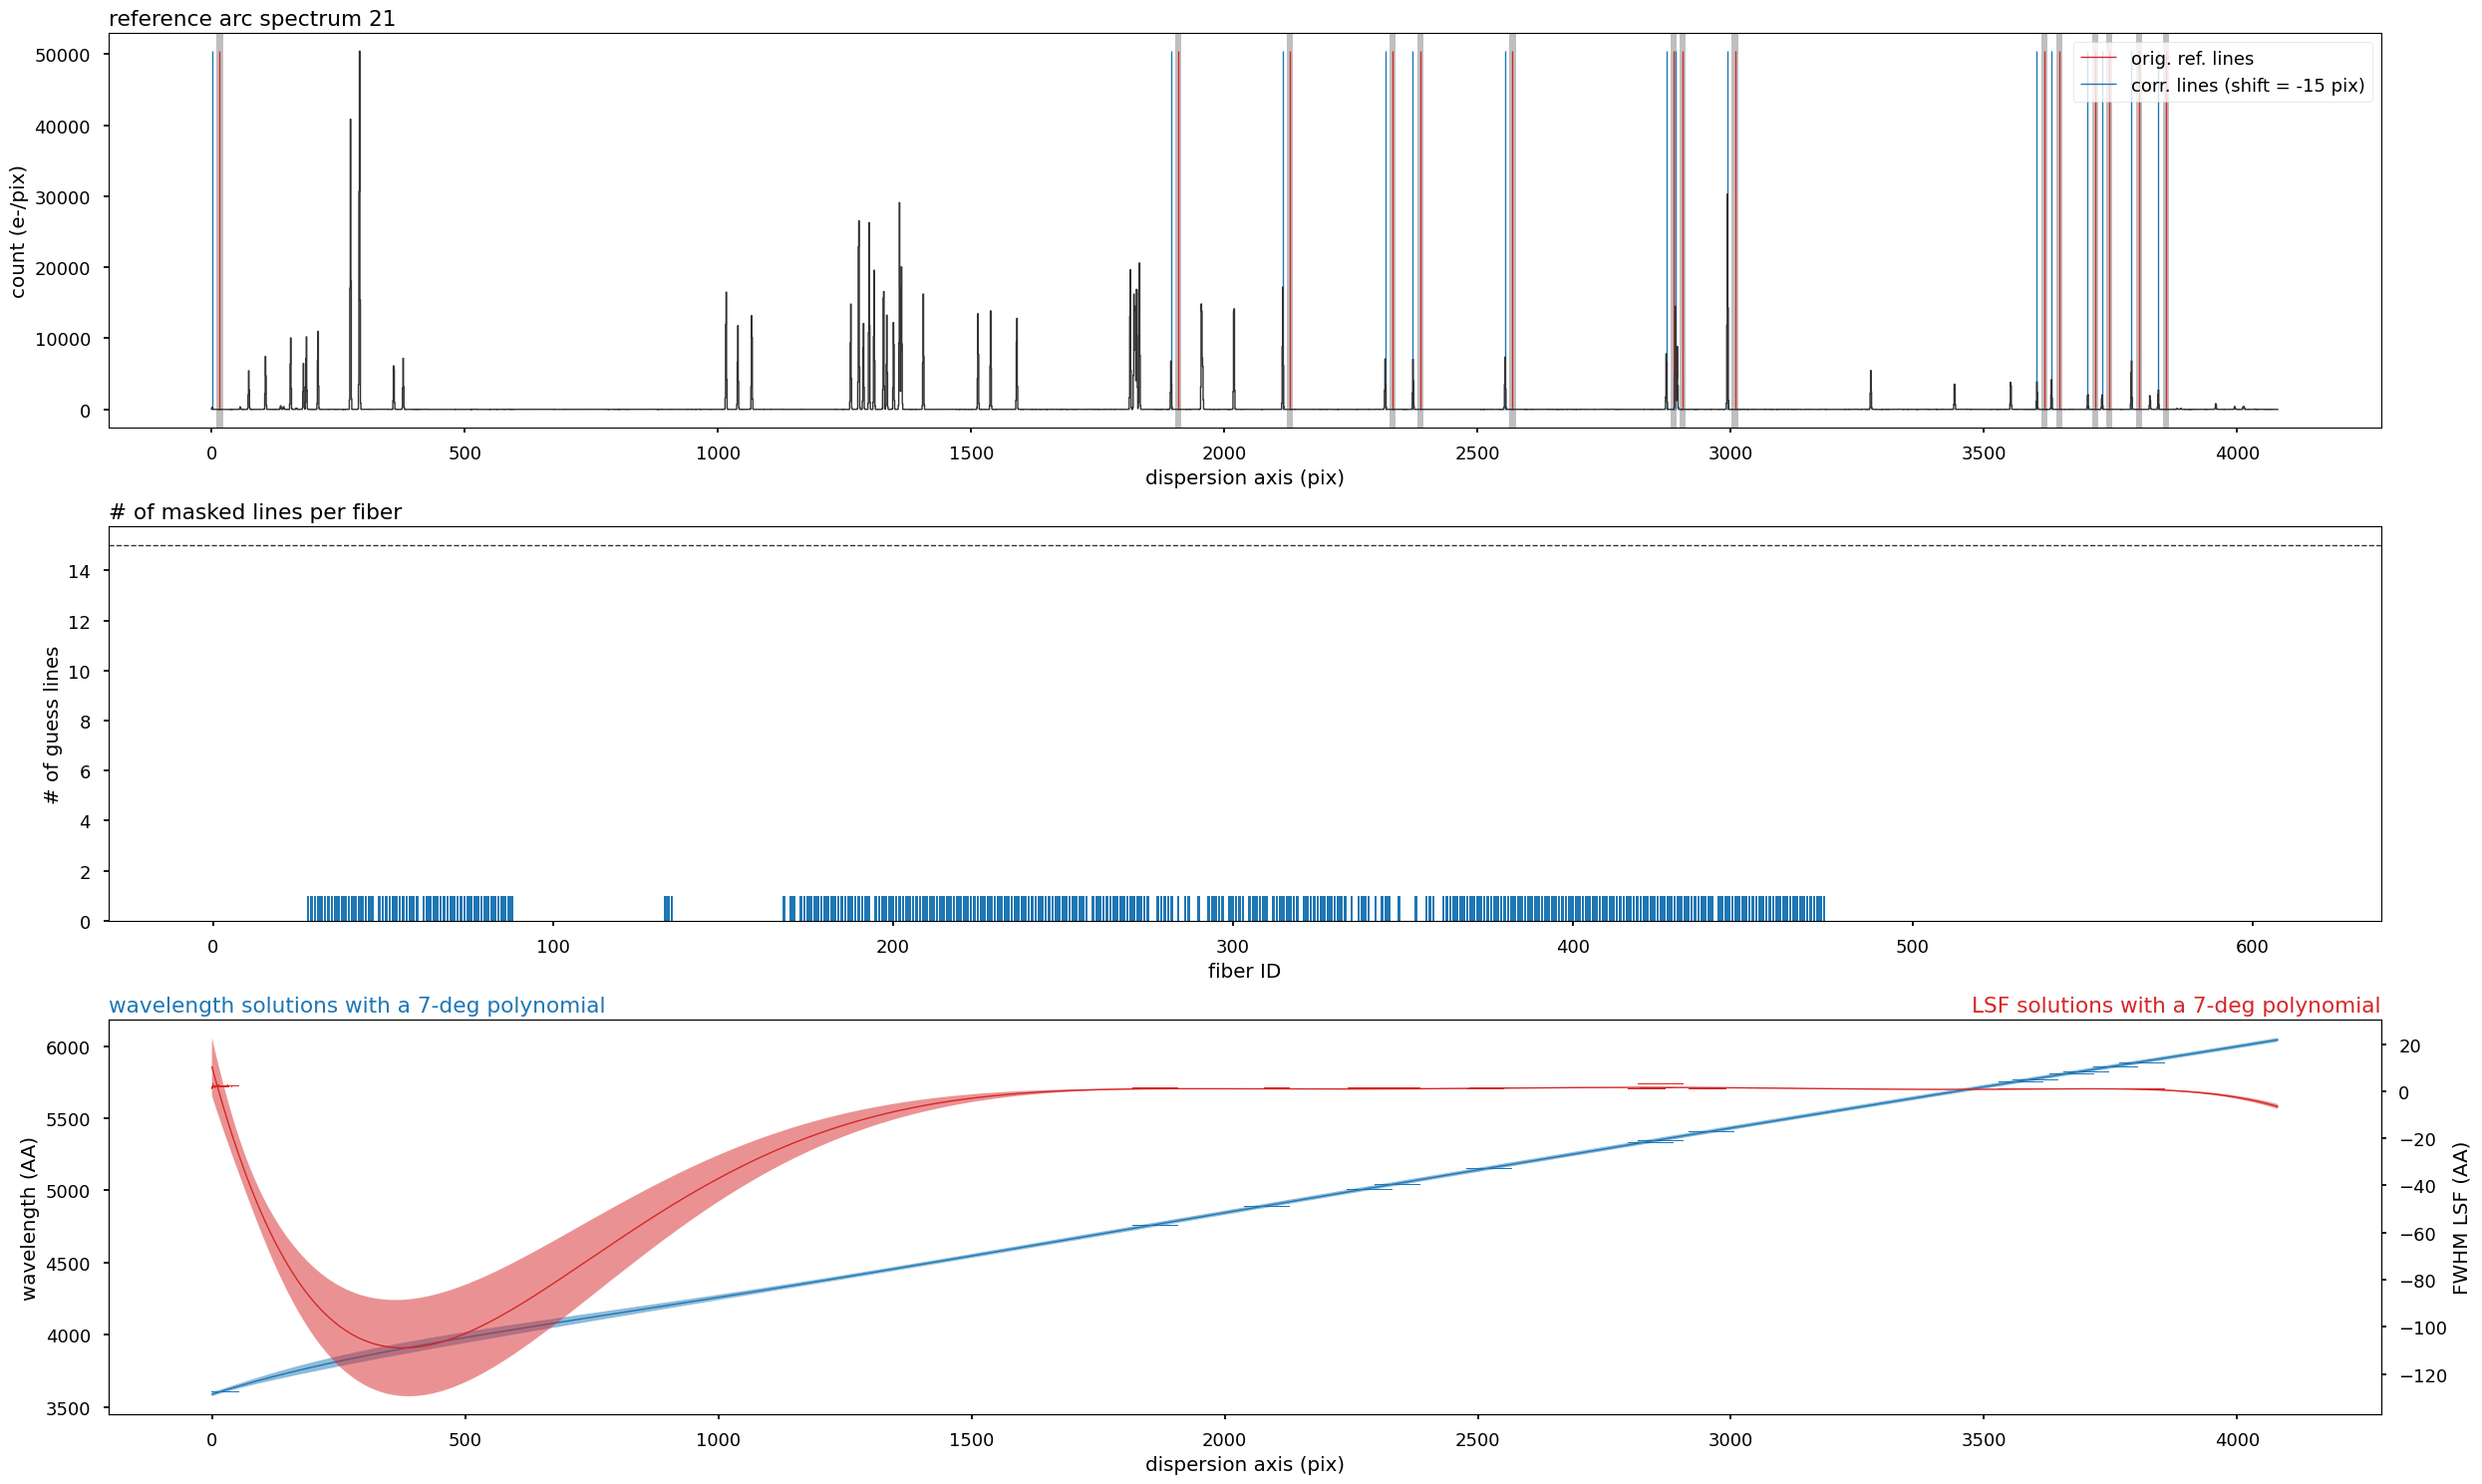

[INFO]: updating header and writing wavelength/LSF to 'data/lvm-wave-b1-00010001.fits' and 'data/lvm-lsf-b1-00010001.fits'
[INFO]: reading guess lines from '../../python/lvmdrp/etc/lvm-neon_nist_r1.txt'
[INFO]: going to use fiber 319 as reference
[INFO]: number of guess lines in file 27 percentage masked  7.40741 %
[INFO]: going to use 25 guess lines
[INFO]: reading arc from 'data/lvm-xarc-r1-00010001.fits'
[INFO]: calculating shift in guess lines using CC
[INFO]: maximum CC shift = -109 pix
[INFO]: measuring arc lines for each fiber from reference fiber 320, flux limits [200.0, 10.0] and relative flux limits [0.1, 5.0]


measuring arc lines upwards from ref_fiber = 319: 100%|##############################################| 319/319 [00:07<00:00, 40.75fiber/s]
measuring arc lines downwards from ref_fiber = 319: 100%|############################################| 288/288 [00:06<00:00, 45.57fiber/s]


[INFO]: smoothing FWHM of guess lines along cross-dispersion axis using 2-deg polynomials
[INFO]: fitting wavelength solutions using 7-deg polynomials
[INFO]: finished wavelength fitting with median RMS = 0.0153273 AA (0.0290014 pix)
[INFO]: fitting LSF solutions using 7-deg polynomials
[INFO]: finished LSF fitting with median RMS = 0.00144161 AA (0.00270721 pix)


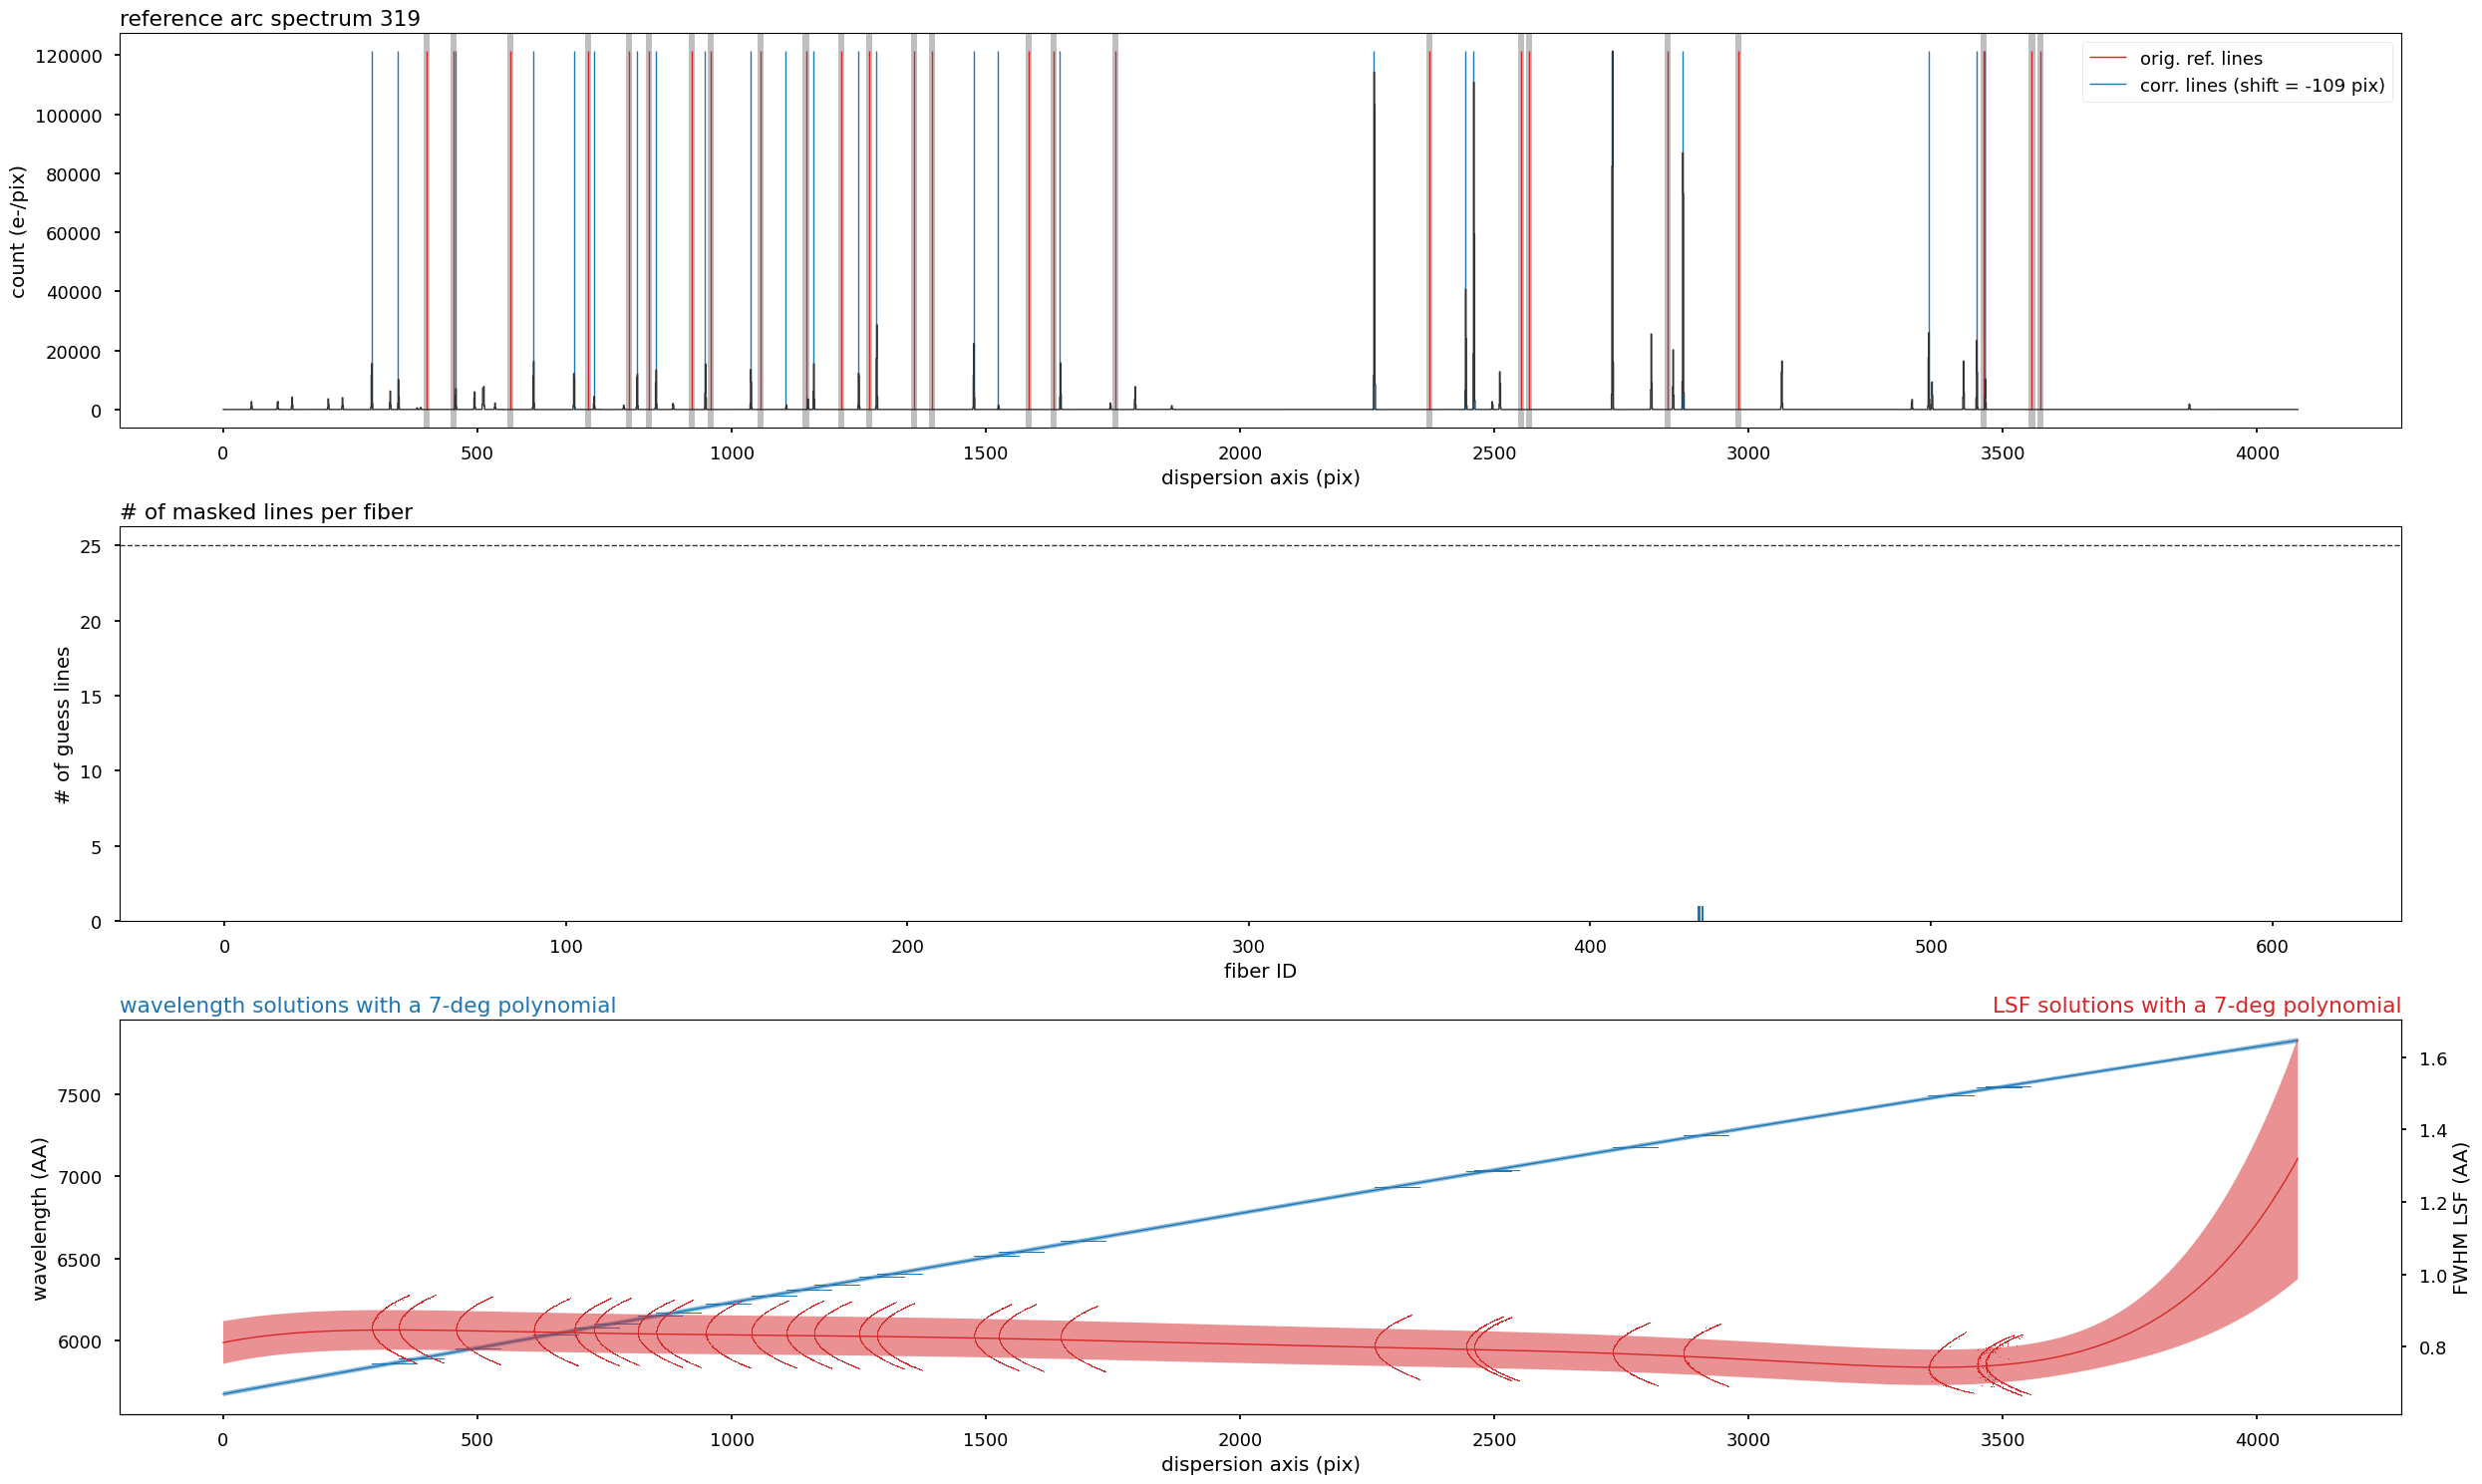

[INFO]: updating header and writing wavelength/LSF to 'data/lvm-wave-r1-00010001.fits' and 'data/lvm-lsf-r1-00010001.fits'
[INFO]: reading guess lines from '../../python/lvmdrp/etc/lvm-neon_nist_z1.txt'
[INFO]: going to use fiber 319 as reference
[INFO]: number of guess lines in file 26 percentage masked  19.2308 %
[INFO]: going to use 21 guess lines
[INFO]: reading arc from 'data/lvm-xarc-z1-00010001.fits'
[INFO]: calculating shift in guess lines using CC
[INFO]: maximum CC shift = -126 pix
[INFO]: measuring arc lines for each fiber from reference fiber 320, flux limits [200.0, 10.0] and relative flux limits [0.1, 5.0]


measuring arc lines upwards from ref_fiber = 319: 100%|##############################################| 319/319 [00:05<00:00, 59.39fiber/s]
measuring arc lines downwards from ref_fiber = 319: 100%|############################################| 288/288 [00:05<00:00, 48.97fiber/s]


[INFO]: smoothing FWHM of guess lines along cross-dispersion axis using 2-deg polynomials
[INFO]: fitting wavelength solutions using 7-deg polynomials
[INFO]: finished wavelength fitting with median RMS = 0.0144817 AA (0.0240216 pix)
[INFO]: fitting LSF solutions using 7-deg polynomials
[INFO]: finished LSF fitting with median RMS = 0.00118288 AA (0.00197012 pix)


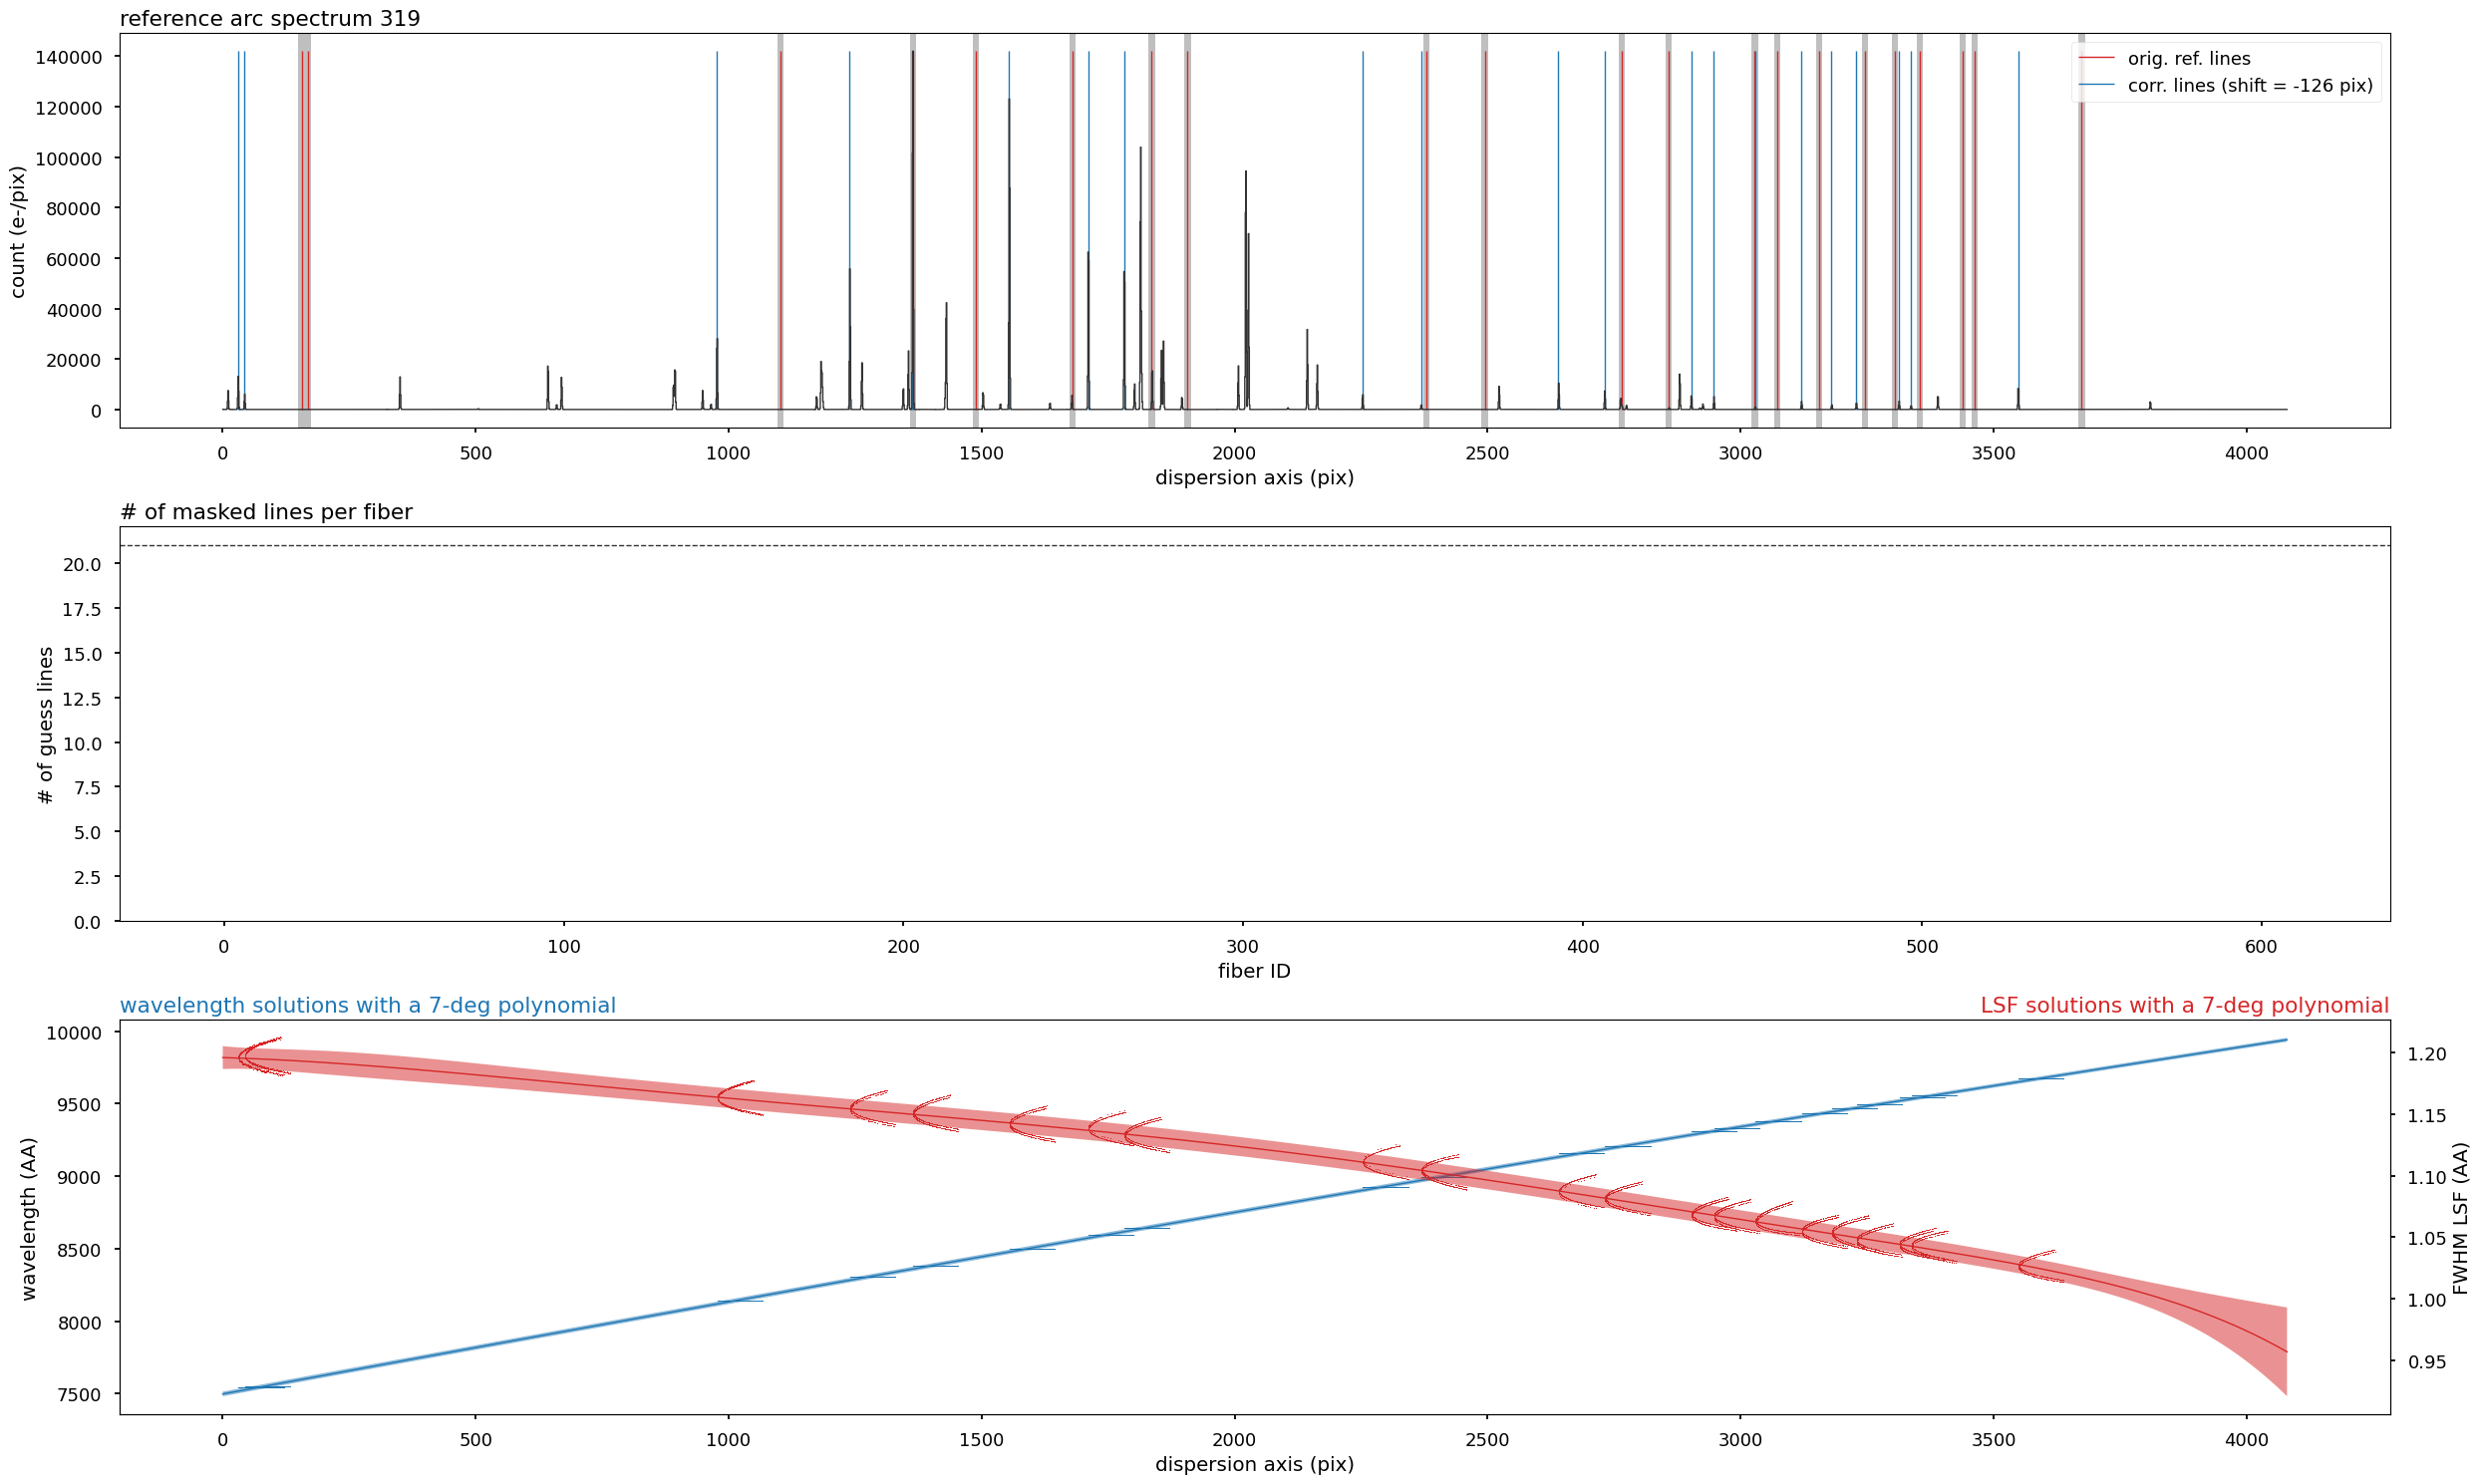

[INFO]: updating header and writing wavelength/LSF to 'data/lvm-wave-z1-00010001.fits' and 'data/lvm-lsf-z1-00010001.fits'


In [4]:
fiberflats = frames_groups[(unique_groups["imagetyp"]=="flat")&(unique_groups["spec"]=="sp1")&(unique_groups["expnum"]=="00001002")]
arcs = frames_groups[(unique_groups["imagetyp"]=="arc")&(unique_groups["spec"]=="sp1")&(unique_groups["expnum"]=="00010001")]

CHANNEL_WL = {"b1": (3600, 5930), "r1": (5660, 7720), "z1": (7470, 9800)}

ised = 250
coad = 10

for fiberflat_frame, arc_frame in zip(fiberflats, arcs):
    fiberflat_path = fiberflat_frame["path"]
    fiberflat_camera, fiberflat_expnum = fiberflat_frame["camera"], fiberflat_frame["expnum"]
    arc_path = arc_frame["path"]
    arc_camera, arc_expnum = arc_frame["camera"], arc_frame["expnum"]
    
    wave_range = CHANNEL_WL[arc_camera]

    imageMethod.extractSpec_drp(
        in_image=out_main_path.format(kind="carc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        out_rss=out_main_path.format(kind="xarc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        in_trace=out_main_path.format(kind="trace", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        method="aperture", aperture=4, plot=2, parallel="auto"
    )

    rssMethod.detWaveSolution_drp(
        in_arc=out_main_path.format(kind="xarc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        out_wave=out_main_path.format(kind="wave", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        out_lsf=out_main_path.format(kind="lsf", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        in_ref_lines=f"../../python/lvmdrp/etc/lvm-neon_nist_{arc_camera}.txt",
        ref_fiber=ised, poly_disp=7, poly_fwhm=7, poly_cros=2, plot=1
    )

    rssMethod.createPixTable_drp(
        in_rss=out_main_path.format(kind="xarc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        out_rss=out_main_path.format(kind="warc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        arc_wave=out_main_path.format(kind="wave", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        arc_fwhm=out_main_path.format(kind="lsf", camera=arc_camera, expnum=arc_expnum, ext="fits")
    )
    
    rssMethod.resampleWave_drp(
        in_rss=out_main_path.format(kind="warc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        out_rss=out_main_path.format(kind="harc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        start_wave=wave_range[0], end_wave=wave_range[1], disp_pix=1.0, method="linear",
        err_sim=10, parallel="auto", extrapolate=True
    )

Text(0.5, 1.0, "camera = 'b1'")

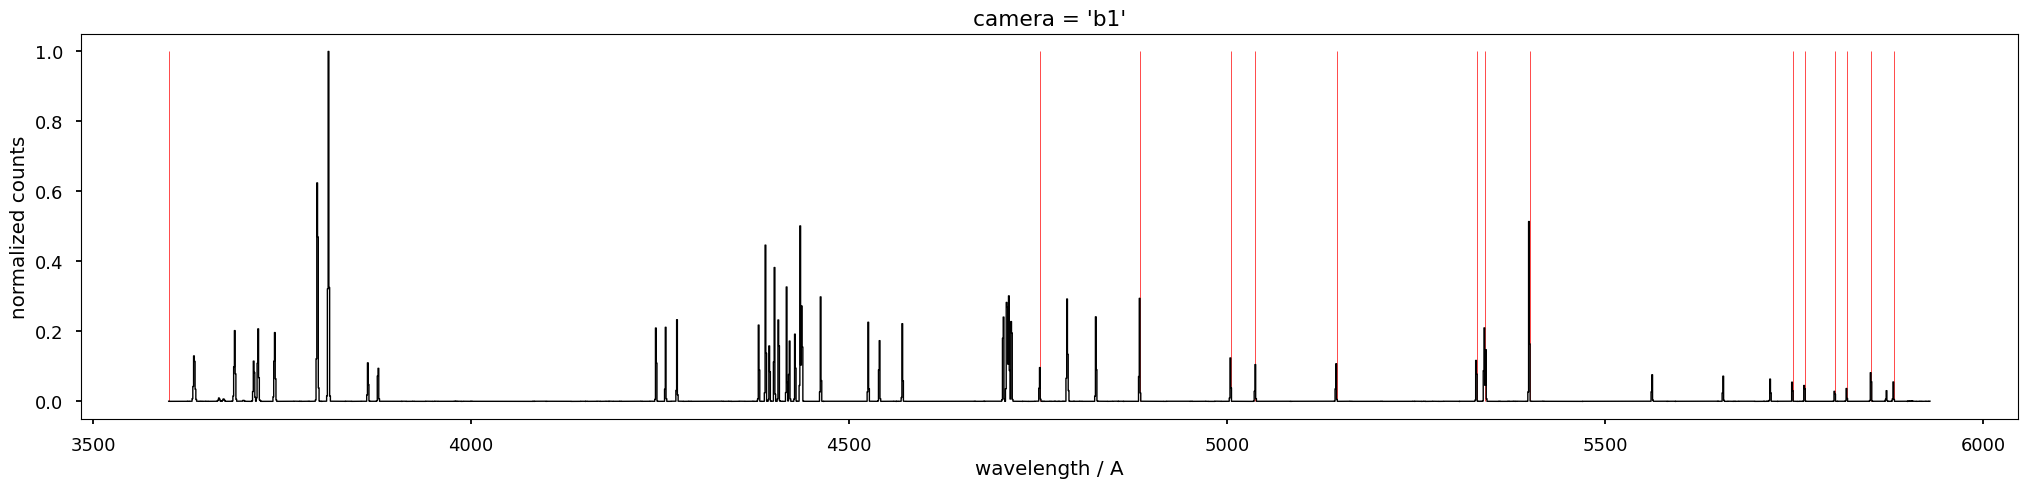

In [5]:
camera = "b1"

with open(f"../../python/lvmdrp/etc/lvm-neon_nist_{camera}.txt") as f:
    f.readline()
    _, lines_wav, _ = np.loadtxt(f, unpack=True)
    lines_int = np.ones_like(lines_wav)
    lines_min = np.zeros_like(lines_wav)

warc = rss.RSS()
warc.loadFitsData(out_main_path.format(kind="harc", camera=camera, expnum=arc_expnum, ext="fits"))

plt.figure(figsize=(25,5))
plt.vlines(lines_wav, lines_min, lines_int / lines_int, lw=0.5, ls="-", color="r")
plt.step(warc._wave, warc._data[ised]/np.nanmax(warc._data[ised]), color="k", lw=1)
plt.xlabel("wavelength / A")
plt.ylabel("normalized counts")
plt.title(f"{camera = }")

In [6]:
rssMethod.joinSpecChannels(
    in_rss=[out_main_path.format(kind="harc", camera=arc_frame["camera"], expnum=arc_frame["expnum"], ext="fits") for arc_frame in arcs],
    out_rss=out_main_path.format(kind="jarc", camera="sp1", expnum=arc_expnum, ext="fits"),
    parallel="auto"
)

Text(0, 0.5, 'normalized counts')

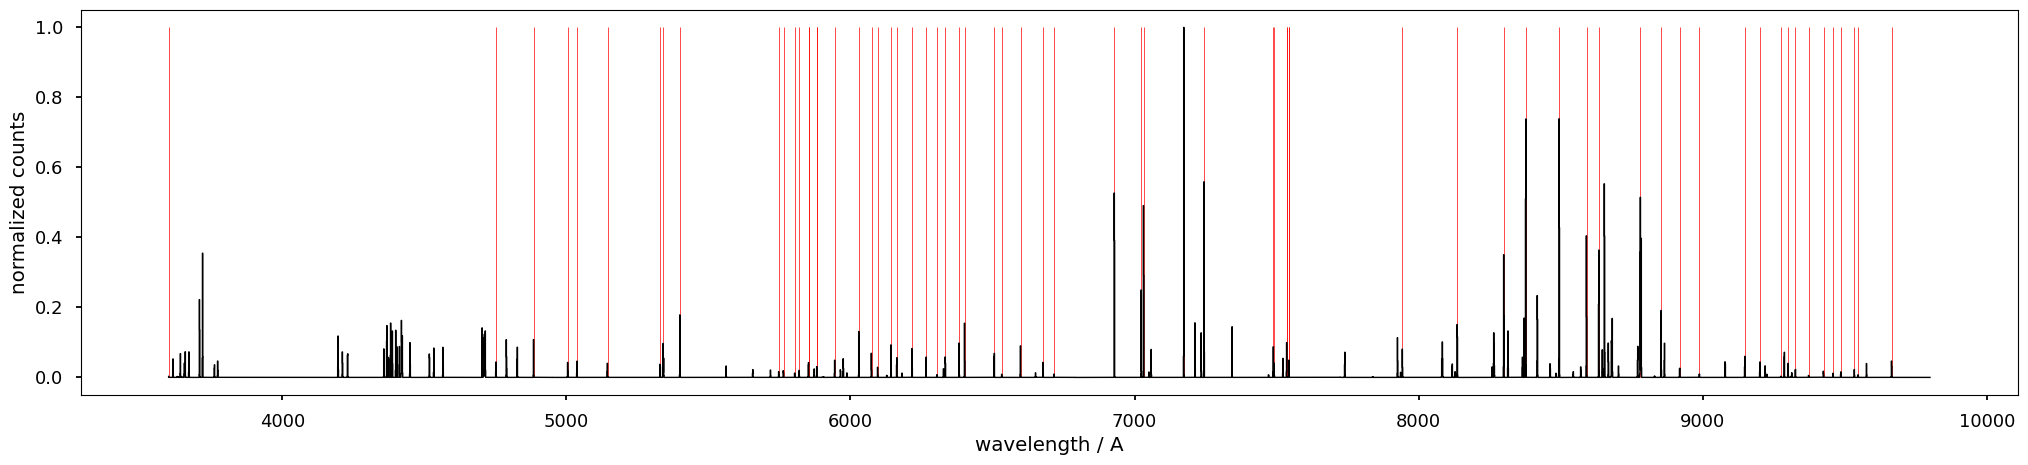

In [7]:
lines_all = []
for camera in CHANNEL_WL.keys():
    with open(f"../../python/lvmdrp/etc/lvm-neon_nist_{camera}.txt") as f:
        f.readline()
        _, lines_wav, _ = np.loadtxt(f, unpack=True)
    lines_all.append(lines_wav)
lines_wav = np.concatenate(lines_all)
lines_int = np.ones_like(lines_wav)
lines_min = np.zeros_like(lines_wav)

jarc = rss.RSS()
jarc.loadFitsData(out_main_path.format(kind="jarc", camera="sp1", expnum=arc_expnum, ext="fits"))

plt.figure(figsize=(25,5))
plt.vlines(lines_wav, lines_min, lines_int / lines_int, lw=0.5, ls="-", color="r")
plt.step(jarc._wave, jarc._data[300]/np.nanmax(jarc._data[300]), color="k", lw=1)
plt.xlabel("wavelength / A")
plt.ylabel("normalized counts")